In [1]:
import copy
import itertools
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from pynufft import NUFFT
from scipy import signal as sci_signal
from scipy import stats
from scipy.constants import c
from scipy.stats import median_abs_deviation, norm

from csromer.base import Dataset
from csromer.dictionaries import DiscreteWavelet, UndecimatedWavelet
from csromer.io import Reader, Writer
from csromer.objectivefunction import L1, L2, TSV, TV, Chi2, OFunction
from csromer.optimization import FISTA, GradientBasedMethod
from csromer.reconstruction import Parameter
from csromer.simulation import FaradayThickSource, FaradayThinSource
from csromer.transformers import Gridding
from csromer.transformers.dfts import NDFT1D, NUFFT1D
from csromer.utils import Gaussian, complex_to_real, real_to_complex

In [2]:
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rcParams.update(
    {
        "font.family": "serif",
        "text.usetex": True,
        "pgf.rcfonts": False,
        "pgf.texsystem": 'pdflatex',  # default is xetex
    }
)

plt.rc('font', size=MEDIUM_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)  # legend fontsize

In [3]:
def pol_dist(s_nu):
    a = np.random.normal(loc=0.051, scale=0.004, size=s_nu.shape).astype(np.float32)
    b = np.random.normal(loc=0.388, scale=0.007, size=s_nu.shape).astype(np.float32)
    log_pol_fraction = -a * np.log(s_nu * 1000.0) + b
    pol_fraction = np.exp(log_pol_fraction)
    return pol_fraction * s_nu

In [4]:
def chi2_calc(residuals):
    if residuals.dtype == np.complex64 or residuals.dtype == np.complex128:
        data = (residuals.real * residuals.real) + (residuals.imag * residuals.imag)
    else:
        data = residuals**2
    return np.sum(data)

In [5]:
def aicbic(residuals_coeffs, x_coeffs):
    rss = chi2_calc(residuals)
    if x.dtype == np.complex64 or x.dtype == np.complex128:
        df = np.count_nonzero(x.real) + np.count_nonzero(x.imag)
    else:
        df = np.count_nonzero(x)
    l = len(residuals)
    return l * np.log(rss / l) + 2 * df, l * np.log(rss / l) + df * np.log(l)

In [6]:
def aicbic(residuals, x):
    rss = chi2_calc(residuals)
    if x.dtype == np.complex64 or x.dtype == np.complex128:
        df = np.count_nonzero(x.real) + np.count_nonzero(x.imag)
        lcoeffs = 2 * len(x)
    else:
        df = np.count_nonzero(x)
        lcoeffs = len(x)
    l = len(residuals)
    print("len(coeffs):", lcoeffs)
    print("l:", l)
    print("df:", df)
    print("rss:", rss)
    print("rss/l", rss / l)
    print("log(rss/l)", np.log(rss / l))
    print("log(l)", np.log(l))
    return l * np.log(rss / l) + 2 * df, l * np.log(rss / l) + df * np.log(l)

In [7]:
np.random.seed(666)

In [8]:
#nu = np.linspace(start=1.008e9, stop=2.031e9, num=1000)  # VLA
#nu = np.linspace(start=0.89e9, stop=1.681e9, num=1000)  # MeerKAT Larry's config
#nu = np.linspace(start=0.887e9, stop=1.38e9, num=1000) # MIGHTEE config
nu = np.linspace(start=1.25446e9, stop=1.76634e9, num=1000) # eMERLIN config
#nu = np.linspace(start=0.09e9, stop=0.2e9, num=1000)

In [9]:
flux_max = 0.0668622  # Jy/beam at 1.27962918 GHz
noise_I = 3.23964e-06  # Jy/beam at 1.27962918 GHz
flux_min = 5. * noise_I  # Jy/beam at 1.27962918 GHz

In [10]:
s_nu_sources = np.random.uniform(low=flux_min, high=flux_max,size=2).astype(np.float32)

In [11]:
p_sources = pol_dist(s_nu_sources)

In [12]:
p_sources

array([0.0555036 , 0.06669743], dtype=float32)

In [13]:
peak_thinsource = p_sources[0]
peak_thicksource = p_sources[1]

In [14]:
thinsource = FaradayThinSource(nu=nu, s_nu=peak_thinsource, phi_gal=-500., spectral_idx=0.7)

In [15]:
#140 JVLA
# 95 MeerKAT
thicksource = FaradayThickSource(
    nu=nu, s_nu=peak_thicksource, phi_fg=100., phi_center=500., spectral_idx=0.7
)

In [16]:
thinsource.simulate()
thicksource.simulate()

In [17]:
simsource = thinsource + thicksource

In [18]:
#simsource.l2_ref = simsource.calculate_l2ref()

In [19]:
#simsource.l2_ref

In [20]:
original_source = copy.deepcopy(simsource)

In [21]:
remove_channels_seed = int(time.time())
remove_channels_seed

1672708201

In [22]:
#simsource.remove_channels(0.1, np.random.RandomState(1648643337))
#simsource.remove_channels(0.1, np.random.RandomState(1648650067))
simsource.remove_channels(0.2)

In [23]:
peak_thinsource

0.0555036

In [24]:
peak_thicksource

0.066697426

In [25]:
applied_noise = 0.01 * peak_thinsource

In [26]:
applied_noise * 1000.0

0.5550359934568405

In [27]:
#simsource.data = np.random.normal(loc=0.0, scale=applied_noise, size=simsource.m) + 1j * np.random.normal(loc=0.0, scale=applied_noise, size=simsource.m)

In [28]:
#simsource.apply_noise(2.2804e-02 + 2.38714e-02j)
simsource.apply_noise(applied_noise)

In [29]:
simsource.theo_noise

1.962348623270559e-05

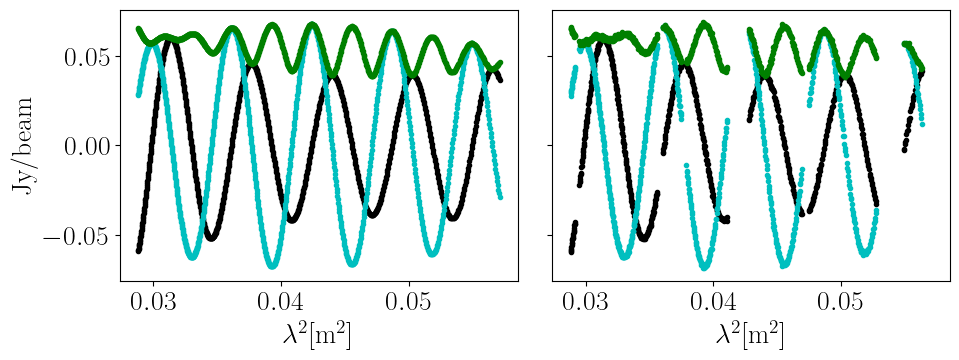

In [30]:
fig, ax = plt.subplots(figsize=(10, 4), nrows=1, ncols=2, sharex=True, sharey=True)

ax[0].plot(original_source.lambda2, original_source.data.real, 'k.', label=r"Stokes $Q$")
ax[0].plot(original_source.lambda2, original_source.data.imag, 'c.', label=r"Stokes $U$")
ax[0].plot(original_source.lambda2, np.abs(original_source.data), 'g.', label=r"$|P|$")
ax[0].set_xlabel(r'$\lambda^2$[m$^{2}$]')
ax[0].set_ylabel(r'Jy/beam')

ax[1].plot(simsource.lambda2, simsource.data.real, 'k.', label=r"Stokes $Q$")
ax[1].plot(simsource.lambda2, simsource.data.imag, 'c.', label=r"Stokes $U$")
ax[1].plot(simsource.lambda2, np.abs(simsource.data), 'g.', label=r"$|P|$")
ax[1].set_xlabel(r'$\lambda^2$[m$^{2}$]')
plt.tight_layout()

In [31]:
sigma_qu = 0.5 * (np.std(simsource.data.real) + np.std(simsource.data.imag))
sigma_qu

0.039443964658893174

In [32]:
dataset = simsource

In [33]:
parameter = Parameter()
original_parameter = Parameter()

In [34]:
original_parameter.calculate_cellsize(dataset=original_source, oversampling=12)

FWHM of the main peak of the RMTF: 122.383 rad/m^2
Maximum recovered width structure: 109.058 rad/m^2
Maximum Faraday Depth to which one has more than 50% sensitivity: 61130.341


In [35]:
parameter.calculate_cellsize(dataset=dataset, oversampling=12)

FWHM of the main peak of the RMTF: 125.874 rad/m^2
Maximum recovered width structure: 109.058 rad/m^2
Maximum Faraday Depth to which one has more than 50% sensitivity: 50286.572


In [36]:
original_parameter.n

13440

In [37]:
parameter.n

11040

In [38]:
nufft_original = NUFFT1D(dataset=original_source, parameter=original_parameter)
nufft = NUFFT1D(dataset=dataset, parameter=parameter)

In [39]:
dft = NDFT1D(dataset=dataset, parameter=parameter)
dft_original = NDFT1D(dataset=original_source, parameter=original_parameter)

In [40]:
F_dirty = dft.backward(dataset.data)
F_dirty_original = dft_original.backward(original_source.data)

rmtf_original = dft_original.RMTF()
rmtf = dft.RMTF()

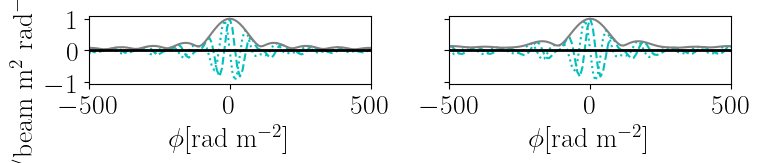

In [41]:
fig, ax = plt.subplots(figsize=(8, 2), nrows=1, ncols=2, sharex=True, sharey=True)

ax[0].plot(original_parameter.phi, rmtf_original.real, 'c--', label=r"Stokes $Q$")
ax[0].plot(original_parameter.phi, rmtf_original.imag, 'c:', label=r"Stokes $U$")
ax[0].plot(original_parameter.phi, np.abs(rmtf_original), '-', c='grey', label=r"|P|")
#plt.plot([-200., -200.], [0., 0.0035], ls='-', lw=2., c='black')
ax[0].plot(original_parameter.phi, np.zeros(len(original_parameter.phi)), ls='-', lw=2., c='black')
ax[0].set_xlabel(r'$\phi$[rad m$^{-2}$]')
ax[0].set_ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
#plt.legend(loc='upper right')
ax[0].set_xlim([-500, 500])

ax[1].plot(parameter.phi, rmtf.real, 'c--', label=r"Stokes $Q$")
ax[1].plot(parameter.phi, rmtf.imag, 'c:', label=r"Stokes $U$")
ax[1].plot(parameter.phi, np.abs(rmtf), '-', c='grey', label=r"|P|")
#plt.plot([-200., -200.], [0., 0.0035], ls='-', lw=2., c='black')
ax[1].plot(parameter.phi, np.zeros(len(parameter.phi)), ls='-', lw=2., c='black')
ax[1].set_xlabel(r'$\phi$[rad m$^{-2}$]')
#ax[1].set_ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
#plt.legend(loc='upper right')
ax[1].set_xlim([-500, 500])

plt.tight_layout()

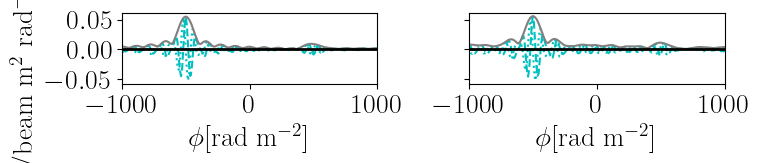

In [42]:
fig, ax = plt.subplots(figsize=(8, 2), nrows=1, ncols=2, sharex=True, sharey=True)

ax[0].plot(original_parameter.phi, F_dirty_original.real, 'c--', label=r"Stokes $Q$")
ax[0].plot(original_parameter.phi, F_dirty_original.imag, 'c:', label=r"Stokes $U$")
ax[0].plot(original_parameter.phi, np.abs(F_dirty_original), '-', c='grey', label=r"|P|")
#plt.plot([-200., -200.], [0., 0.0035], ls='-', lw=2., c='black')
ax[0].plot(original_parameter.phi, np.zeros(len(original_parameter.phi)), ls='-', lw=2., c='black')
ax[0].set_xlabel(r'$\phi$[rad m$^{-2}$]')
ax[0].set_ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
#plt.legend(loc='upper right')
ax[0].set_xlim([-1000, 1000])

ax[1].plot(parameter.phi, F_dirty.real, 'c--', label=r"Stokes $Q$")
ax[1].plot(parameter.phi, F_dirty.imag, 'c:', label=r"Stokes $U$")
ax[1].plot(parameter.phi, np.abs(F_dirty), '-', c='grey', label=r"|P|")
#plt.plot([-200., -200.], [0., 0.0035], ls='-', lw=2., c='black')
ax[1].plot(parameter.phi, np.zeros(len(parameter.phi)), ls='-', lw=2., c='black')
ax[1].set_xlabel(r'$\phi$[rad m$^{-2}$]')
#ax[1].set_ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
#plt.legend(loc='upper right')
ax[1].set_xlim([-1000, 1000])

plt.tight_layout()

In [43]:
F_dirty_nufft = nufft.backward(dataset.data)

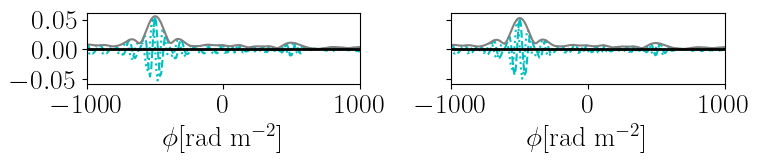

In [44]:
fig, ax = plt.subplots(figsize=(8, 2), nrows=1, ncols=2, sharex=True, sharey=True)

ax[0].plot(parameter.phi, F_dirty.real, 'c--', label=r"Stokes $Q$")
ax[0].plot(parameter.phi, F_dirty.imag, 'c:', label=r"Stokes $U$")
ax[0].plot(parameter.phi, np.abs(F_dirty), '-', c='grey', label=r"|P|")
#plt.plot([-200., -200.], [0., 0.0035], ls='-', lw=2., c='black')
ax[0].plot(parameter.phi, np.zeros(len(parameter.phi)), ls='-', lw=2., c='black')
ax[0].set_xlabel(r'$\phi$[rad m$^{-2}$]')
#ax[0].set_ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
#plt.legend(loc='upper right')
ax[0].set_xlim([-1000, 1000])

ax[1].plot(parameter.phi, F_dirty_nufft.real, 'c--', label=r"Stokes $Q$")
ax[1].plot(parameter.phi, F_dirty_nufft.imag, 'c:', label=r"Stokes $U$")
ax[1].plot(parameter.phi, np.abs(F_dirty_nufft), '-', c='grey', label=r"|P|")
#plt.plot([-200., -200.], [0., 0.0035], ls='-', lw=2., c='black')
ax[1].plot(parameter.phi, np.zeros(len(parameter.phi)), ls='-', lw=2., c='black')
ax[1].set_xlabel(r'$\phi$[rad m$^{-2}$]')
#ax[1].set_ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
#plt.legend(loc='upper right')
ax[1].set_xlim([-1000, 1000])

plt.tight_layout()

In [45]:
idx_noise = np.where(np.abs(parameter.phi) > 0.8 * parameter.max_faraday_depth)
noise_F = 0.5 * (
    median_abs_deviation(F_dirty[idx_noise].real, scale="normal") +
    median_abs_deviation(F_dirty[idx_noise].imag, scale="normal")
)
noise_F

0.00019328631871822518

In [46]:
dataset.theo_noise

1.962348623270559e-05

In [47]:
noise_from_w = 1.0 / np.sqrt(np.sum(dataset.w))
noise_from_w * 1000.0

0.01962348623270559

In [48]:
wav = None
#wav = DiscreteWavelet(wavelet_name="haar", mode="periodization", append_signal=True)
#wav = UndecimatedWavelet(wavelet_name="haar", mode="periodization", append_signal=True)

In [49]:
parameter.n

11040

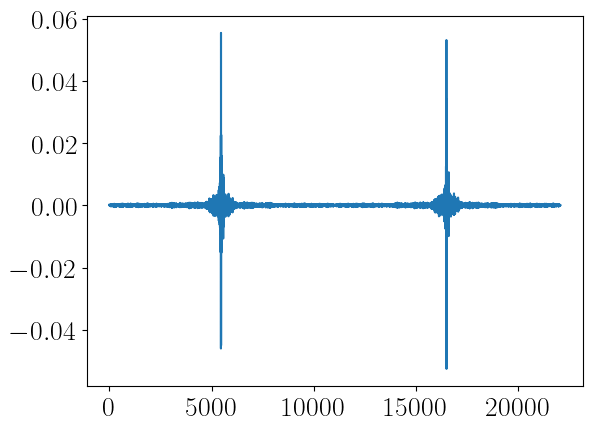

In [50]:
parameter.data = F_dirty
parameter.complex_data_to_real()
if wav is not None:
    print(wav.calculate_max_level(parameter.data))
    parameter.data = wav.decompose(parameter.data)
    #if wav.append_signal is True:
        #parameter.data[0:2 * len(F_dirty)] = 0.0
plt.plot(parameter.data)

In [51]:
parameter.n

22080

In [52]:
len(parameter.data)

22080

In [53]:
np.mean(dataset.sigma)

0.0005550360074266791

In [54]:
lambda_l1 = np.sqrt(dataset.m + 2 * np.sqrt(dataset.m)) * np.sqrt(2) * np.mean(dataset.sigma)

if wav is not None:
    lambda_l1 *= 2.0
    
lambda_tsv = 0.0
chi2 = Chi2(dft_obj=nufft, wavelet=wav)
l1 = L1(reg=lambda_l1)
tsv = TSV(reg=lambda_tsv)

F_func = [chi2, l1]
f_func = [chi2]
g_func = [l1]

F_obj = OFunction(F_func)
f_obj = OFunction(f_func)
g_obj = OFunction(g_func)

In [55]:
lambda_l1

0.022972973771488454

In [56]:
dataset.theo_noise

1.962348623270559e-05

In [57]:
reconstruction_noise = dataset.theo_noise

if wav is not None:
    reconstruction_noise *= 2.0

opt = FISTA(
    guess_param=parameter,
    F_obj=F_obj,
    fx=chi2,
    gx=g_obj,
    noise=reconstruction_noise,
    verbose=False
)

obj, X = opt.run()
print(obj)

1692.3831180906488


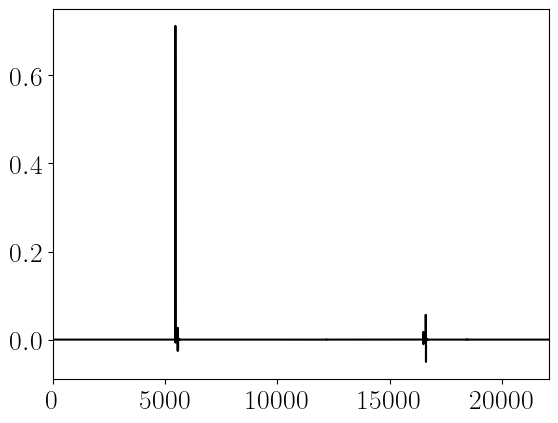

In [58]:
plt.plot(X.data, color = 'black')
#plt.axhline(y = 0, color = 'white', linestyle = 'dashed', linewidth=1)
plt.xlim([0, len(X.data)])
plt.savefig("l1-norm.pdf", dpi=300)

In [59]:
if wav is not None:
    X.data = wav.reconstruct(X.data)
X.real_data_to_complex()

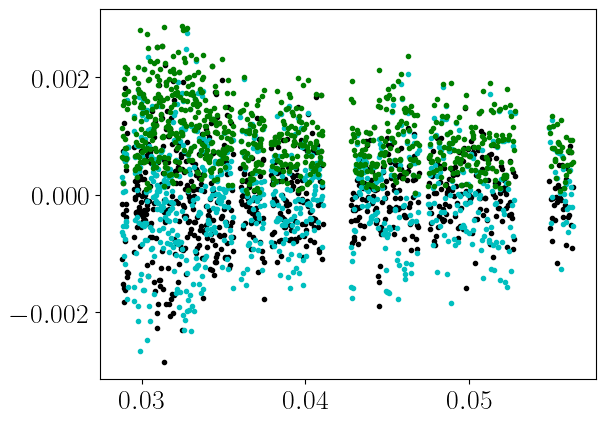

In [60]:
plt.plot(dataset.lambda2, dataset.residual.real, 'k.', label=r"Stokes $Q$")
plt.plot(dataset.lambda2, dataset.residual.imag, 'c.', label=r"Stokes $U$")
plt.plot(dataset.lambda2, np.abs(dataset.residual), 'g.', label=r"$|P|$")

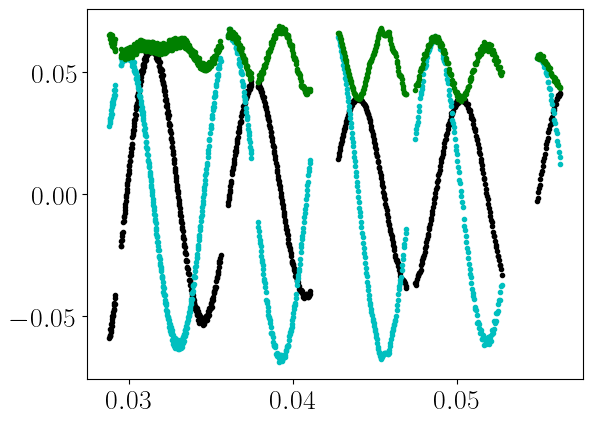

In [61]:
plt.plot(dataset.lambda2, dataset.model_data.real, 'k.', label=r"Stokes $Q$")
plt.plot(dataset.lambda2, dataset.model_data.imag, 'c.', label=r"Stokes $U$")
plt.plot(dataset.lambda2, np.abs(dataset.model_data), 'g.', label=r"$|P|$")

In [62]:
sigma_res = 0.5 * (np.std(dataset.residual.real) + np.std(dataset.residual.imag))

In [63]:
sigma_res * 1000.0

0.804291157695221

In [64]:
#dataset.l2_ref = dataset.calculate_l2ref()

In [65]:
F_residual = dft.backward(dataset.residual)

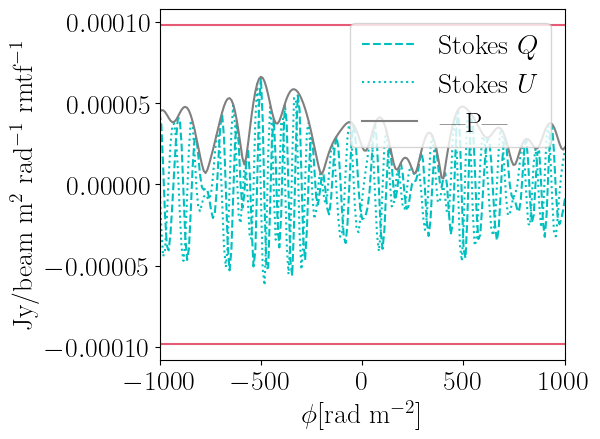

In [66]:
plt.plot(parameter.phi, F_residual.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, F_residual.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(F_residual), '-', c='grey', label=r"|P|")
#plt.plot([-200.,-200.],[0.,0.0035],ls='-',lw=2.,c='black')
#plt.plot(parameter.phi,np.zeros(len(parameter.phi)),ls='-',lw=2.,c='black')
plt.axhline(y=5 * dataset.theo_noise, color='crimson', alpha=0.7)
plt.axhline(y=-5 * dataset.theo_noise, color='crimson', alpha=0.7)
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
plt.legend(loc='upper right')
plt.xlim([-1000, 1000])
plt.tight_layout()
#plt.savefig("fds_sim1.png", dpi=100)

In [67]:
rms_residual = 0.5 * (np.std(F_residual.real) + np.std(F_residual.imag))
rms_residual * 1000.0

0.022775124307372607

In [68]:
dataset.theo_noise * 1000.0

0.01962348623270559

In [69]:
noise_F * 1000.0

0.1932863187182252

In [70]:
applied_noise * 1000.0

0.5550359934568405

In [71]:
sigma_qu * 1000.0

39.44396465889317

In [72]:
model_2 = dft.backward(dataset.model_data)

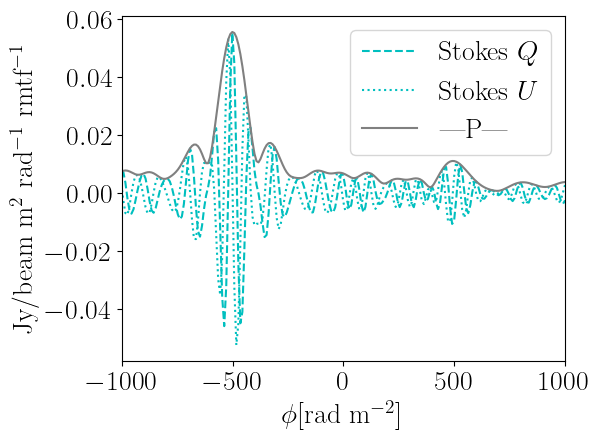

In [73]:
plt.plot(parameter.phi, model_2.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, model_2.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(model_2), '-', c='grey', label=r"|P|")
#plt.plot([-200.,-200.],[0.,0.0035],ls='-',lw=2.,c='black')
#plt.plot(parameter.phi,np.zeros(len(parameter.phi)),ls='-',lw=2.,c='black')
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
plt.legend(loc='upper right')
plt.xlim([-1000, 1000])
plt.tight_layout()
#plt.savefig("fds_sim1.png", dpi=100)

In [74]:
residual_faraday = F_dirty - model_2

In [75]:
parameter.rmtf_fwhm/parameter.cellsize

13.81727158948686

In [76]:
conv_model = X.convolve() + F_residual

Convolving with Gaussian kernel where FWHM 125.874 rad/m^2 - pixels 14, sigma 53.454 rad/m^2 - pixels 6


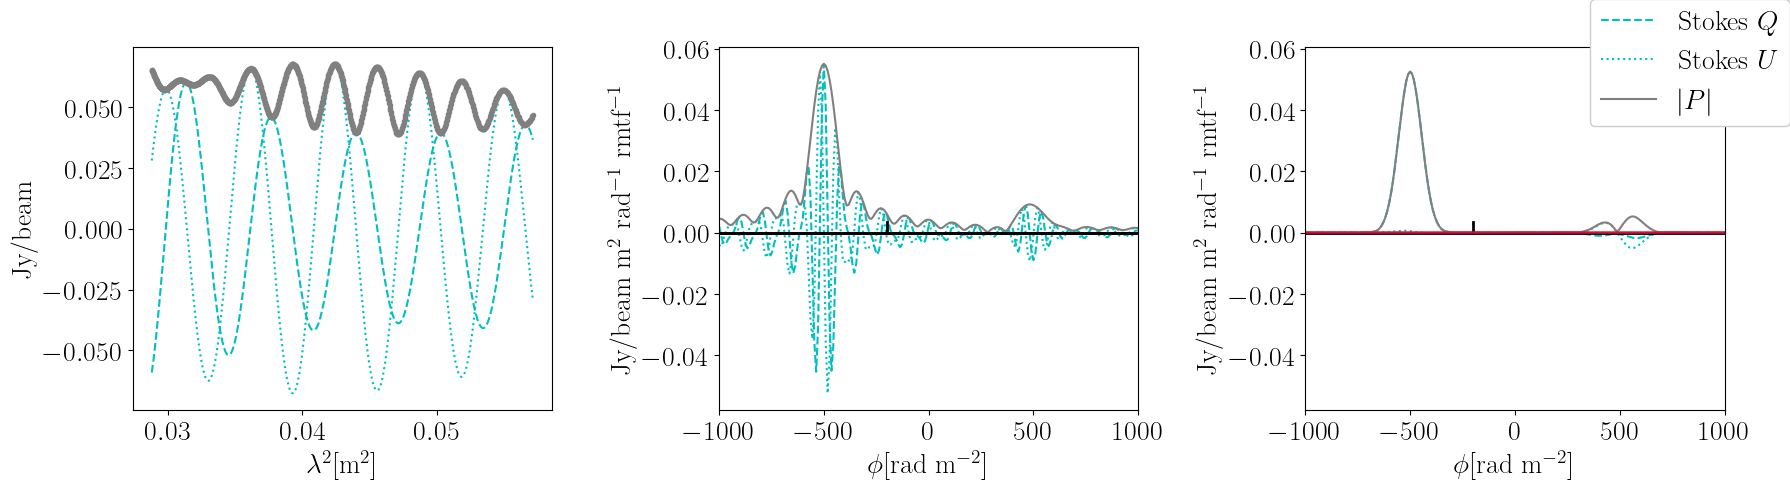

In [77]:
fig = plt.figure(figsize=(18, 5))
#fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(18, 5))
ax1 = fig.add_subplot(1, 3, 1)
ax1.plot(original_source.lambda2, original_source.data.real, 'c--', label=r"Stokes $Q$")
ax1.plot(original_source.lambda2, original_source.data.imag, 'c:', label=r"Stokes $U$")
ax1.plot(original_source.lambda2, np.abs(original_source.data), '.', color="grey", label=r"$|P|$")
ax1.set_xlabel(r'$\lambda^2$[m$^{2}$]')
ax1.set_ylabel(r'Jy/beam')

ax2 = fig.add_subplot(1, 3, 2)
ax2.plot(original_parameter.phi, F_dirty_original.real, 'c--', label=r"Stokes $Q$")
ax2.plot(original_parameter.phi, F_dirty_original.imag, 'c:', label=r"Stokes $U$")
ax2.plot(original_parameter.phi, np.abs(F_dirty_original), '-', c='grey', label=r"|P|")
ax2.plot(original_parameter.phi, np.zeros(len(original_parameter.phi)), ls='-', lw=2., c='black')
ax2.plot([-200., -200.], [0., 0.0035], ls='-', lw=2., c='black')
#ax2.plot([130., 130.], [0., 0.0035], ls='-', lw=2., c='black')
#ax2.plot([270., 270.], [0., 0.0035], ls='-', lw=2., c='black')
#ax2.plot([130., 270.], [0.0035, 0.0035], ls='-', lw=2., c='black')
ax2.plot(original_parameter.phi, np.zeros(len(original_parameter.phi)), ls='-', lw=2., c='black')
#ax2.axhline (y = 5*original_source.theo_noise*1000.0, color = 'crimson', alpha=0.7)
#ax2.axhline (y = -5*original_source.theo_noise*1000.0, color = 'crimson', alpha=0.7)
ax2.set_xlabel(r'$\phi$[rad m$^{-2}$]')
ax2.set_ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
ax2.set_xlim([-1000, 1000])

ax3 = fig.add_subplot(1, 3, 3, sharex=ax2, sharey=ax2)
ax3.plot(parameter.phi, conv_model.real, 'c--', label=r"Stokes $Q$")
ax3.plot(parameter.phi, conv_model.imag, 'c:', label=r"Stokes $U$")
ax3.plot(parameter.phi, np.abs(conv_model), '-', c='grey', label=r"$|P|$")
ax3.plot([-200., -200.], [0., 0.0035], ls='-', lw=2., c='black')
#ax3.plot([130., 130.], [0., 0.0035], ls='-', lw=2., c='black')
#ax3.plot([270., 270.], [0., 0.0035], ls='-', lw=2., c='black')
#ax3.plot([130., 270.], [0.0035, 0.0035], ls='-', lw=2., c='black')

ax3.plot(parameter.phi, np.zeros(len(parameter.phi)), ls='-', lw=2., c='black')
#ax3.set_xlim([-1000,1000])
ax3.axhline(y=5 * dataset.theo_noise, color='crimson', alpha=0.7)
ax3.axhline(y=-5 * dataset.theo_noise, color='crimson', alpha=0.7)
ax3.set_xlabel(r'$\phi$[rad m$^{-2}$]')
ax3.set_ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')

handles, labels = ax3.get_legend_handles_labels()
legend = fig.legend(handles, labels, loc="upper right", borderaxespad=0)
legend.get_frame().set_alpha(1.0)
fig.tight_layout()
fig.savefig("thin.pdf", dpi=500)

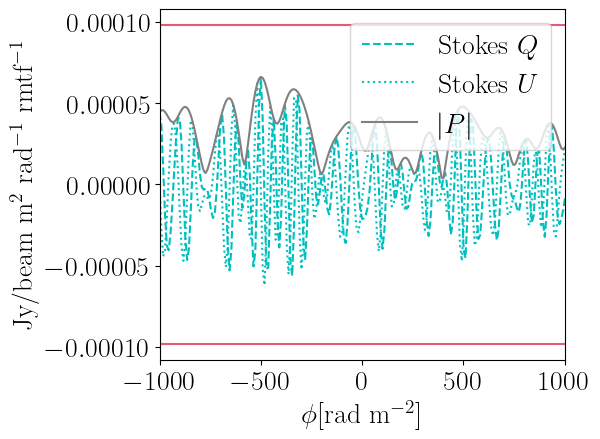

In [78]:
plt.plot(parameter.phi, residual_faraday.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, residual_faraday.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(residual_faraday), '-', c='grey', label=r"$|P|$")
#plt.plot([-200.,-200.],[0.,0.0035],ls='-',lw=2.,c='black')
#plt.plot(parameter.phi,np.zeros(len(parameter.phi)),ls='-',lw=2.,c='black')
plt.axhline(y=5 * dataset.theo_noise, color='crimson', alpha=0.7)
plt.axhline(y=-5 * dataset.theo_noise, color='crimson', alpha=0.7)
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
plt.legend(loc='upper right')
plt.xlim([-1000, 1000])
plt.tight_layout()
#plt.savefig("fds_sim1.png", dpi=100)

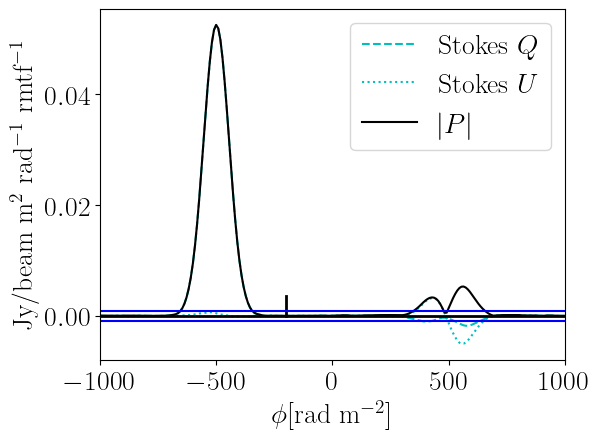

In [79]:
plt.plot(parameter.phi, conv_model.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, conv_model.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(conv_model), 'k-', label=r"$|P|$")
plt.plot([-200., -200.], [0., 0.0035], ls='-', lw=2., c='black')
plt.plot(parameter.phi, np.zeros(len(parameter.phi)), ls='-', lw=2., c='black')
plt.xlim([-1000, 1000])
plt.axhline(y=5 * noise_F, color='b')
plt.axhline(y=-5 * noise_F, color='b')
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
plt.legend(loc='upper right')
plt.tight_layout()
#plt.savefig("restored.png", dpi=100)

In [80]:
np.nanmax(np.abs(conv_model))

0.05246467500763945

In [81]:
np.nanmax(np.abs(conv_model)) / rms_residual

2303.59555010885

In [82]:
P = np.sqrt(np.max(np.abs(conv_model))**2 - (2.3 * rms_residual**2))

In [83]:
parameter.rmtf_fwhm / (2 * P / rms_residual)

0.02732115856613803

In [84]:
residual_1d = np.concatenate([residual_faraday.real, residual_faraday.imag])
#residual_1d = np.concatenate([dataset.residual.real, dataset.residual.imag])
stat, p = stats.jarque_bera(residual_1d)

In [85]:
print("stat={0:.3f}, p={1:.3f}".format(stat, p))

stat=678.043, p=0.000


In [86]:
p

0.0

In [87]:
if p > 0.05:
    print("Probably Gaussian")
else:
    print("Probably not Gaussian")

Probably not Gaussian


In [88]:
residual_all = np.concatenate([F_residual.real, F_residual.imag]) * 1000.0

In [89]:
frequency, bins = np.histogram(residual_all, bins="auto", density=True)
frequency /= np.max(frequency)
xmin = np.min(bins)
xmax = np.max(bins)
dist = np.abs(xmax - xmin)
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, 0.0, dataset.theo_noise * 1000.0)
p /= np.max(p)

/tmp/ipykernel_747124/4118689364.py:42: MatplotlibDeprecationWarning: The remove function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax[0, 3].get_shared_x_axes().remove(ax[0, 3])


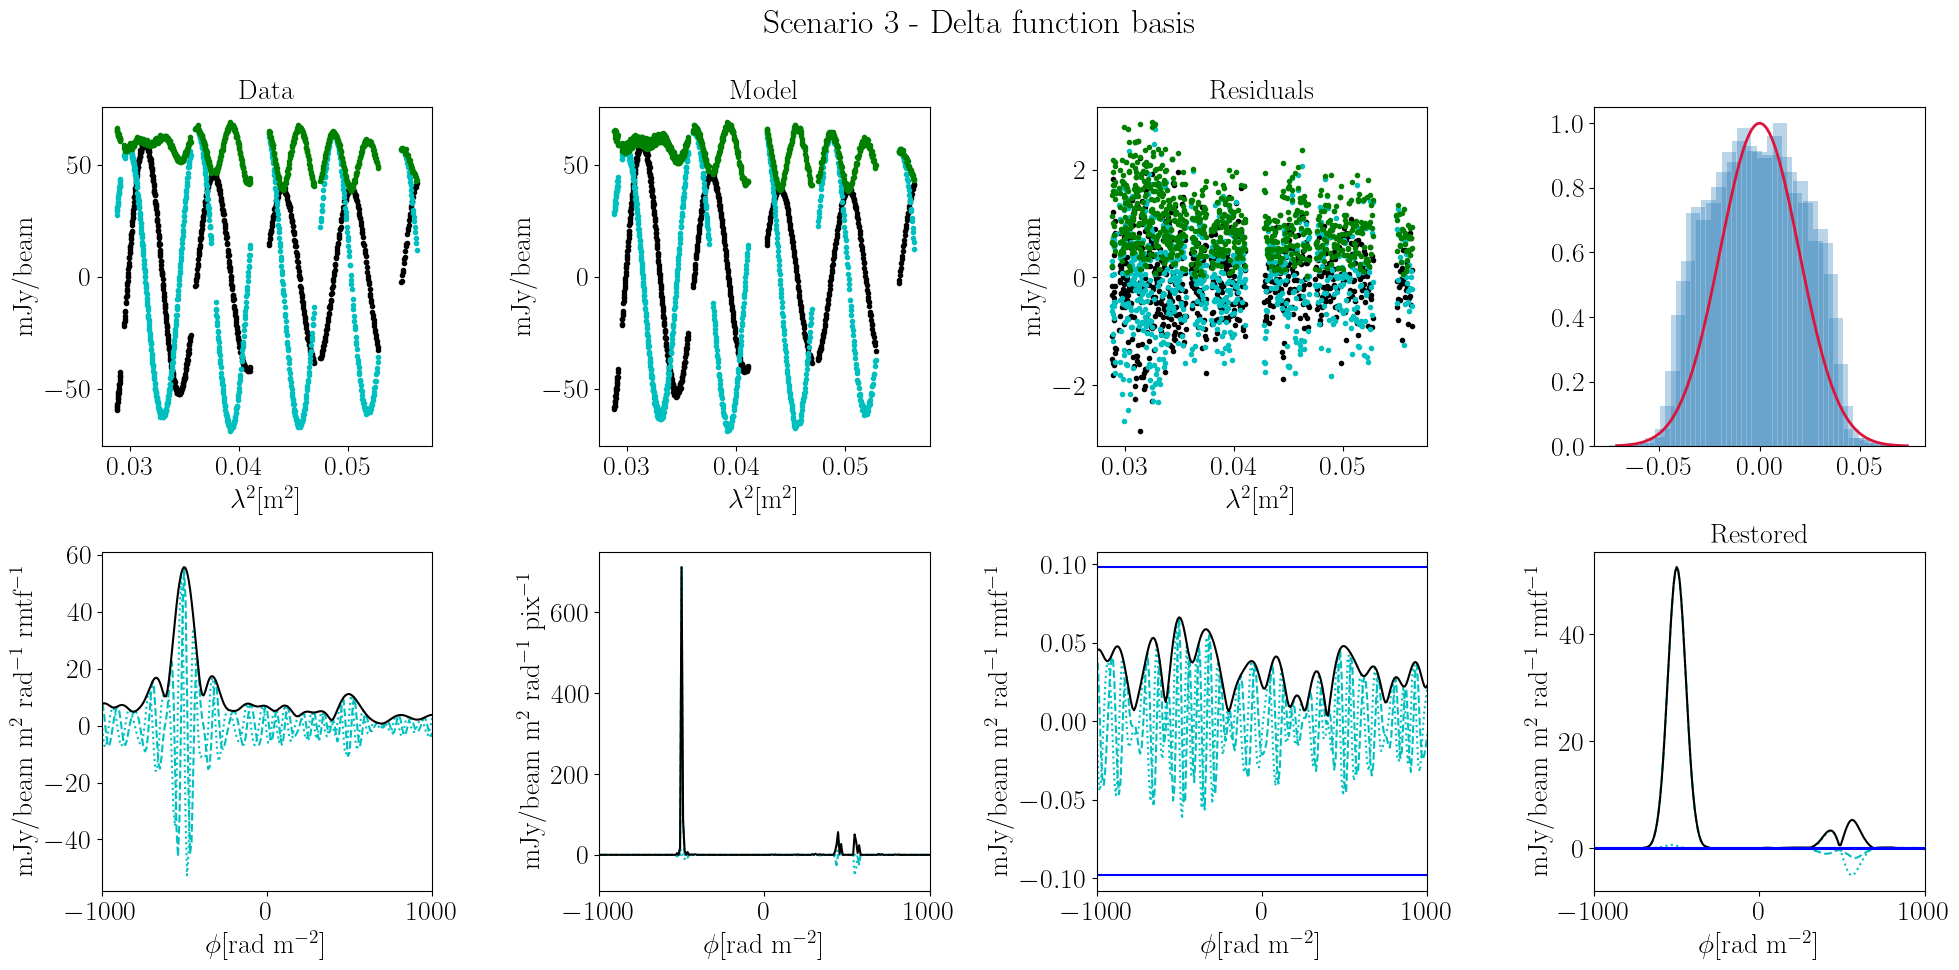

In [90]:
fig, ax = plt.subplots(nrows=2, ncols=4, sharex='row', figsize=(20, 10))

# Data
ax[0, 0].plot(dataset.lambda2, dataset.data.real * 1000.0, 'k.', label=r"Stokes $Q$")
ax[0, 0].plot(dataset.lambda2, dataset.data.imag * 1000.0, 'c.', label=r"Stokes $U$")
ax[0, 0].plot(dataset.lambda2, np.abs(dataset.data) * 1000.0, 'g.', label=r"$|P|$")
ax[0, 0].set_xlabel(r'$\lambda^2$[m$^{2}$]')
ax[0, 0].set_ylabel(r'mJy/beam')
ax[0, 0].title.set_text("Data")

ax[1, 0].plot(parameter.phi, F_dirty.real * 1000.0, 'c--', label=r"Stokes $Q$")
ax[1, 0].plot(parameter.phi, F_dirty.imag * 1000.0, 'c:', label=r"Stokes $U$")
ax[1, 0].plot(parameter.phi, np.abs(F_dirty) * 1000.0, 'k-', label=r"|P|")
ax[1, 0].set_xlabel(r'$\phi$[rad m$^{-2}$]')
ax[1, 0].set_ylabel(r'mJy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
ax[1, 0].set_xlim([-1000, 1000])

# Model
ax[0, 1].plot(dataset.lambda2, dataset.model_data.real * 1000.0, 'k.', label=r"Stokes $Q$")
ax[0, 1].plot(dataset.lambda2, dataset.model_data.imag * 1000.0, 'c.', label=r"Stokes $U$")
ax[0, 1].plot(dataset.lambda2, np.abs(dataset.model_data) * 1000.0, 'g.', label=r"$|P|$")
ax[0, 1].set_xlabel(r'$\lambda^2$[m$^{2}$]')
ax[0, 1].set_ylabel(r'mJy/beam')
ax[0, 1].title.set_text("Model")
# Model
ax[1, 1].plot(parameter.phi, X.data.real * 1000.0, 'c--', label=r"Stokes $Q$")
ax[1, 1].plot(parameter.phi, X.data.imag * 1000.0, 'c:', label=r"Stokes $U$")
ax[1, 1].plot(parameter.phi, np.abs(X.data) * 1000.0, 'k-', label=r"$|P|$")
ax[1, 1].set_xlabel(r'$\phi$[rad m$^{-2}$]')
ax[1, 1].set_ylabel(r'mJy/beam m$^2$ rad$^{-1}$ pix$^{-1}$')
ax[1, 1].set_xlim([-1000, 1000])

# Residual

ax[0, 2].plot(dataset.lambda2, dataset.residual.real * 1000.0, 'k.', label=r"Stokes $Q$")
ax[0, 2].plot(dataset.lambda2, dataset.residual.imag * 1000.0, 'c.', label=r"Stokes $U$")
ax[0, 2].plot(dataset.lambda2, np.abs(dataset.residual) * 1000.0, 'g.', label=r"$|P|$")
ax[0, 2].set_xlabel(r'$\lambda^2$[m$^{2}$]')
ax[0, 2].set_ylabel(r'mJy/beam')
ax[0, 2].title.set_text("Residuals")

ax[0, 3].get_shared_x_axes().remove(ax[0, 3])
# Create and assign new ticker
xticker = matplotlib.axis.Ticker()
ax[0, 3].xaxis.major = xticker

# The new ticker needs new locator and formatters
xloc = matplotlib.ticker.AutoLocator()
xfmt = matplotlib.ticker.ScalarFormatter()

ax[0, 3].xaxis.set_major_locator(xloc)
ax[0, 3].xaxis.set_major_formatter(xfmt)

ax[0, 3].bar(bins[:-1], frequency, width=dist / 20, alpha=0.3)
ax[0, 3].plot(x, p, 'crimson', linewidth=2)

ax[1, 2].plot(parameter.phi, F_residual.real * 1000.0, 'c--', label=r"Stokes $Q$")
ax[1, 2].plot(parameter.phi, F_residual.imag * 1000.0, 'c:', label=r"Stokes $U$")
ax[1, 2].plot(parameter.phi, np.abs(F_residual) * 1000.0, 'k-', label=r"$|P|$")
ax[1, 2].axhline(y=5 * dataset.theo_noise * 1000.0, color='b')
ax[1, 2].axhline(y=-5 * dataset.theo_noise * 1000.0, color='b')
ax[1, 2].set_xlabel(r'$\phi$[rad m$^{-2}$]')
ax[1, 2].set_ylabel(r'mJy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
ax[1, 2].set_xlim([-1000, 1000])

ax[1, 3].plot(parameter.phi, conv_model.real * 1000.0, 'c--', label=r"Stokes $Q$")
ax[1, 3].plot(parameter.phi, conv_model.imag * 1000.0, 'c:', label=r"Stokes $U$")
ax[1, 3].plot(parameter.phi, np.abs(conv_model) * 1000.0, 'k-', label=r"$|P|$")
ax[1, 3].axhline(y=5 * dataset.theo_noise * 1000.0, color='b')
ax[1, 3].axhline(y=-5 * dataset.theo_noise * 1000.0, color='b')
ax[1, 3].set_xlim([-1000, 1000])
ax[1, 3].set_xlabel(r'$\phi$[rad m$^{-2}$]')
ax[1, 3].set_ylabel(r'mJy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
ax[1, 3].title.set_text("Restored")

title = "Scenario 3 - "
"""
if isinstance(dataset, FaradayThinSource):
    title += "Scenario 1 - "
elif isinstance(dataset, FaradayThickSource):
    title += "Scenario 2 - "
else:
    title += "Scenario 3 - "
"""
if wav is None:
    title += "Delta function basis "
else:
    if isinstance(wav, DiscreteWavelet):
        if wav.append_signal is True:
            title += "Delta function basis + {0} discrete wavelet ".format(wav.wavelet_name)
        else:
            title += "{0} discrete wavelet ".format(wav.wavelet_name)
    else:
        if wav.append_signal is True:
            title += "Delta function basis + {0} undecimated wavelet ".format(wav.wavelet_name)
        else:
            title += "{0} undecimated wavelet ".format(wav.wavelet_name)
"""
if wav is None:
    title += "- Delta function basis "
else:
    if isinstance(wav, DiscreteWavelet):
        if wav.append_signal is True:
            title += "- Delta function basis + {0} discrete wavelet ".format(wav.wavelet_name)
        else:
            title += "- {0} discrete wavelet ".format(wav.wavelet_name)
    else:
        if wav.append_signal is True:
            title += "- Delta function basis + {0} undecimated wavelet ".format(wav.wavelet_name)
        else:
            title += "- {0} undecimated wavelet ".format(wav.wavelet_name)

if (dataset.w == dataset.w[0]).all():
    title += "uniform weights equal to {0:.3f}".format(dataset.w[0])   
else:
    title += "natural weights "




"""
fig.suptitle(title)
fig.tight_layout()

(-1000.0, 1000.0)

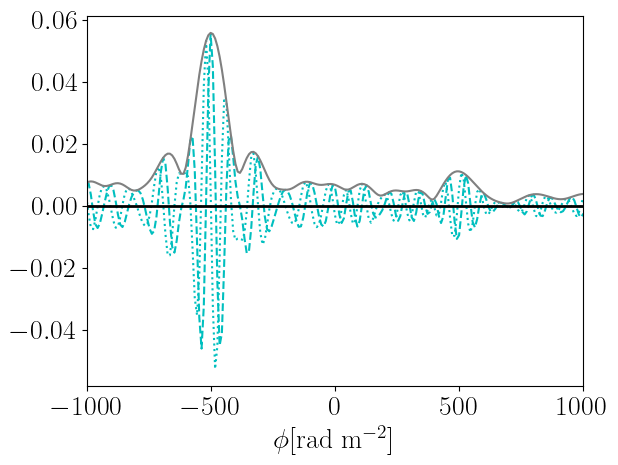

In [91]:
plt.plot(parameter.phi, F_dirty.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, F_dirty.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(F_dirty), '-', c='grey', label=r"|P|")
#plt.plot([-200., -200.], [0., 0.0035], ls='-', lw=2., c='black')
plt.plot(parameter.phi, np.zeros(len(parameter.phi)), ls='-', lw=2., c='black')
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
#ax[0].set_ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
#plt.legend(loc='upper right')
plt.xlim([-1000, 1000])